100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


Epoch [1/10] Loss: 0.1263
Epoch [2/10] Loss: 0.0817
Epoch [3/10] Loss: 0.0699
Epoch [4/10] Loss: 0.0640
Epoch [5/10] Loss: 0.0595
Epoch [6/10] Loss: 0.0551
Epoch [7/10] Loss: 0.0521
Epoch [8/10] Loss: 0.0498
Epoch [9/10] Loss: 0.0477
Epoch [10/10] Loss: 0.0456


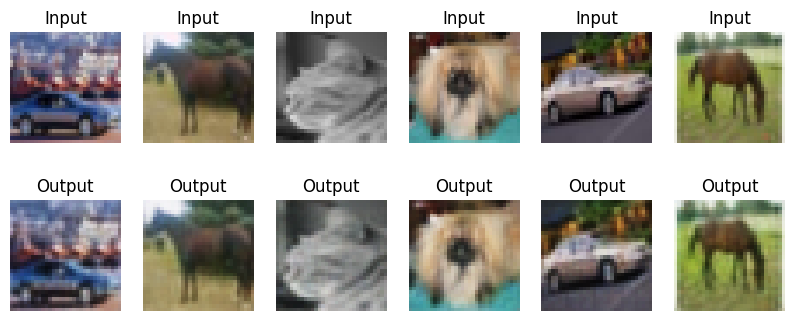

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# =========================
# 1. Load Dataset (Paired)
# =========================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))   # Normalize to [-1, 1]
])

dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

# For baseline, input = output (identity mapping)
# (or you can apply a corruption later)

# =========================
# 2. Encoder-Decoder CNN
# =========================
class EncoderDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),   # 32 -> 16
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # 16 -> 8
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1), # 8 -> 4
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), # 4 -> 8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 8 -> 16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),    # 16 -> 32
            nn.Tanh()   # output in [-1, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EncoderDecoder().to(device)

# =========================
# 3. Loss and Optimizer
# =========================
criterion_L1 = nn.L1Loss()     # MAE
criterion_MSE = nn.MSELoss()   # MSE
optimizer = optim.Adam(model.parameters(), lr=0.0002)

# =========================
# 4. Training Loop
# =========================
epochs = 10

for epoch in range(epochs):
    total_loss = 0

    for images, _ in loader:
        images = images.to(device)

        # For baseline: target = input image
        target = images

        outputs = model(images)

        loss = criterion_L1(outputs, target)   # or MSE

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss/len(loader):.4f}")

# =========================
# 5. Visualization
# =========================
def denormalize(img):
    return img * 0.5 + 0.5   # back to [0,1]

dataiter = iter(loader)
images, _ = next(dataiter)
images = images.to(device)

with torch.no_grad():
    outputs = model(images)

# move to cpu
images = images.cpu()
outputs = outputs.cpu()

# plot
fig, axes = plt.subplots(2, 6, figsize=(10,4))
for i in range(6):
    axes[0,i].imshow(denormalize(images[i]).permute(1,2,0))
    axes[0,i].axis('off')
    axes[0,i].set_title("Input")

    axes[1,i].imshow(denormalize(outputs[i]).permute(1,2,0))
    axes[1,i].axis('off')
    axes[1,i].set_title("Output")

plt.show()
